In [1]:
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.features import rasterize

import pandas as pd
import geopandas as geopd

import numpy as np
import numpy.ma as ma

from tqdm.notebook import tqdm

import os
import warnings

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [2]:
src_path = "/home/iiro/Documents/DIWA/data/temi/Catchment4.shp"
dst_path = "/home/iiro/Documents/DIWA/data/temi/catchment_attr_lvl_4.GPKG"

land_cover_path = "/home/iiro/Documents/GIS-sync/perusdata/syke/corine/clc2018_fi20m/Clc2018_main_classes_hydro.tif"
lc_year = 2018
lc_classes = {1 : "urban", 2 : "agriculture", 3 : "forest", 4 : "peatland", 5: "water"}
lc_columns = [f"{lc_classes[key]}_portion_{lc_year}" for key in lc_classes.keys()]

soil_path = "/home/iiro/Documents/DIWA/data/GTK/maaperä_sliced.gpkg"
soil_classes = {
    "stone": [195110, 195111, 195112, 195312],
    "coarse": [195310],
    "fine": [195410],
    "mixed": [195210],
    "clay": [195413],
    "ooze": [195511, 195618],
    "peat": [19551891, 19551892, 19551822]
    }
soil_columns = [f"{key}_portion" for key in soil_classes]

soil_depth_path = "/home/iiro/Documents/GIS-sync/perusdata/GTK/maapeitepaksuus_1m_epsg3067_tiff_jpg/maapeitepaksuus_1000k.tif"

slope_path = "/media/iiro/T9/gisT7/korkeusmalli_10_m/slope10m.tif"

In [3]:
soil_columns

['stone_portion',
 'coarse_portion',
 'fine_portion',
 'mixed_portion',
 'clay_portion',
 'ooze_portion',
 'peat_portion']

In [4]:
watersheds = geopd.read_file(src_path)
# Deleting sliver polygons
watersheds = watersheds[watersheds.area > 100]

In [5]:
def add_lc_to_watersheds(subwatersheds, land_cover_path, lc_classes, year):
    """
    Adds land cover classification proportions of a spesific year to subwatersheds.

    Parameters:
    subwatersheds (GeoDataFrame): A GeoDataFrame containing subwatershed geometries and attributes.
    land_cover_path (str): Path to the land cover raster file.
    lc_classes (dict): A dictionary mapping land cover class values to their names.
    year (int): The year of the land cover data.
    bounds (tuple): A tuple containing the bounding box coordinates (minx, miny, maxx, maxy).

    Returns:
    GeoDataFrame: The input GeoDataFrame with additional columns for each land cover class proportion.
    """
    place_id = subwatersheds.at[0, 'taso4_id']

    for j, subwatershed in subwatersheds.iterrows():

        subwatershed = geopd.GeoDataFrame(
                dict(zip(list(subwatershed.index), list(subwatershed.values))),
                crs=subwatersheds.crs, geometry='geometry', index=[0])

        minx = subwatershed.bounds.at[0, 'minx']
        miny = subwatershed.bounds.at[0, 'miny']
        maxx = subwatershed.bounds.at[0, 'maxx']
        maxy = subwatershed.bounds.at[0, 'maxy']

        with rasterio.open(land_cover_path) as src:
            profile = src.profile
            values = src.read(
                1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                boundless=True, fill_value=profile['nodata'])
        
        profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
        profile['width'] = values.shape[1]
        profile['height'] = values.shape[0]
        
        area_mask = rasterize(
                subwatershed['geometry'], (profile['height'], profile['width']),
                dtype=profile['dtype'], transform=profile['transform'], all_touched=True)
        
        area = area_mask.sum()
        
        clipped_values = np.where(area_mask == 1, values, 0)
        for key in lc_classes:
            class_name = lc_classes[key]
            class_values = np.where(clipped_values == key, 1, 0)
        
            class_area = class_values.sum()
    
            # Some subwaterhseds cause minor problems 
            warnings.filterwarnings("error")
            
            try:
                class_portion = class_area / area
    
            except:
                class_portion = 0
                print(f"{class_name}_portion was set to zero for watershed {place_id}, subwatershed {j} because {class_area} or {area} were invalid features")
            warnings.filterwarnings("default")
            
            
            subwatersheds.at[j, f"{class_name}_portion_{year}"] = class_portion

    return subwatersheds

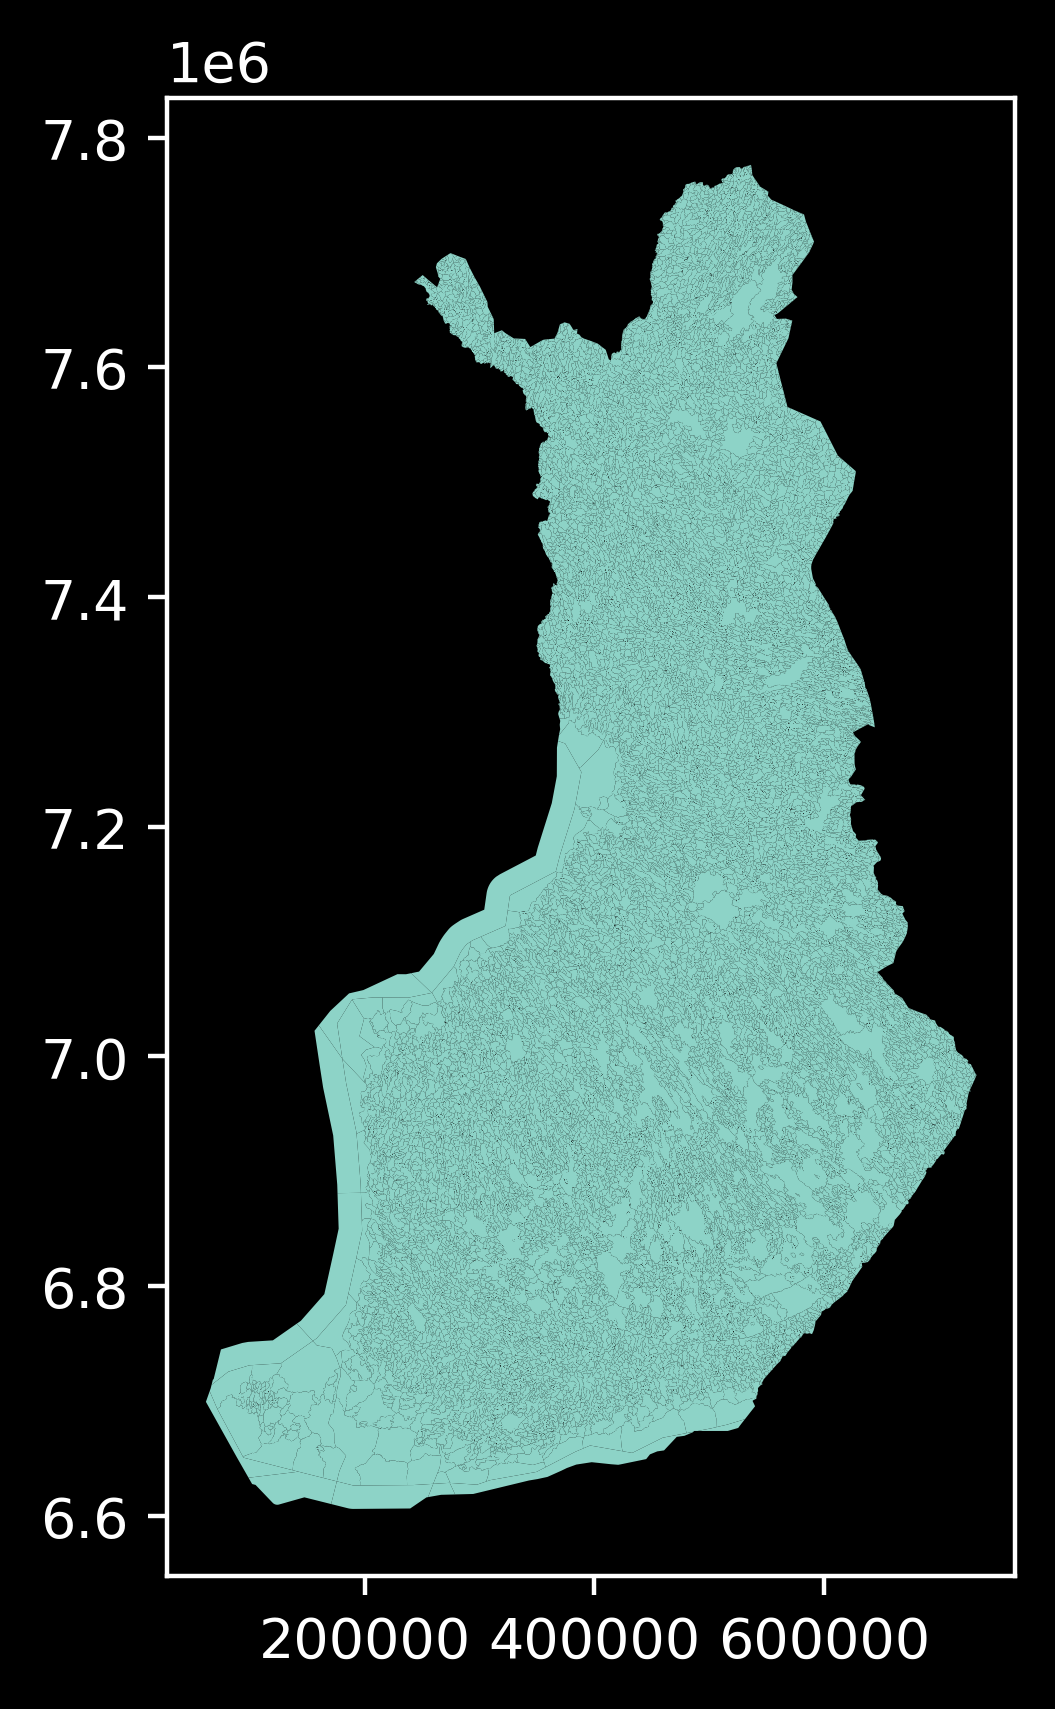

In [6]:
ax = watersheds.plot()

In [7]:
watersheds

,taso4_osai,taso4_osat,taso4_id,osavalu_pa,ylavalu_pa,taso3_osat,taso2_osat,taso1_osat,valtio,muutospvm,Shape_STAr,Shape_STLe,geometry
3,146801179,FI4-68.01.179,46801179,438.48,10142.61,FI4-68.01,FI4-68,FI4,FINO1,2023-05-09,4.384811e+06,13952.055680,"POLYGON ((483054.156 7760246.703, 483097.032 7..."
4,146801173,FI4-68.01.173,46801173,254.73,10156.05,FI4-68.01,FI4-68,FI4,FINO1,2023-05-09,2.547312e+06,9468.193582,"POLYGON ((485505.013 7761402.31, 485525.537 77..."
5,146801180,FI4-68.01.180,46801180,229.65,10404.62,FI4-68.01,FI4-68,FI4,FINO1,2023-05-09,2.296518e+06,10608.835621,"POLYGON ((487914.622 7761690.564, 487940.871 7..."
12,146801198,FI4-68.01.198,46801198,115.35,10663.29,FI4-68.01,FI4-68,FI4,FINO1,2023-05-09,1.153465e+06,11446.639831,"POLYGON ((499462.202 7758634.046, 499504.095 7..."
14,146801191,FI4-68.01.191,46801191,356.43,10647.47,FI4-68.01,FI4-68,FI4,FINO1,2023-05-09,3.564251e+06,10951.190704,"POLYGON ((495355.487 7758443.807, 495368.768 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21800,118202076,FI1-82.02.076,18202076,115467.98,0.00,FI1-82.02,FI1-82,FI1,FI,2023-05-09,1.154680e+09,264660.000000,"MULTIPOLYGON (((110260 6660360, 110260 6660350..."
21801,118202085,FI1-82.02.085,18202085,11278.60,0.00,FI1-82.02,FI1-82,FI1,FI,2023-05-09,1.127860e+08,96040.000000,"MULTIPOLYGON (((120630 6668760, 120630 6668750..."
21802,118202084,FI1-82.02.084,18202084,2881.21,0.00,FI1-82.02,FI1-82,FI1,FI,2023-05-09,2.881210e+07,41780.000000,"POLYGON ((117040 6670560, 117040 6670550, 1170..."
21803,118202014,FI1-82.02.014,18202014,2317.06,23.17,FI1-82.02,FI1-82,FI1,FI,2023-05-09,2.317060e+07,45020.000000,"POLYGON ((99280 6697440, 99280 6697430, 99290 ..."


In [8]:
test_selection = 672

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    #if i < test_selection:
        #continue

    pbar.set_description(f"Processing catchment {i}")
    # Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])
    
    minx = watershed.bounds.at[0, 'minx']
    miny = watershed.bounds.at[0, 'miny']
    maxx = watershed.bounds.at[0, 'maxx']
    maxy = watershed.bounds.at[0, 'maxy']

    """
    Land cover
    """
    #pbar.set_description(f"Doing land cover for catchment {i}")

    watershed = add_lc_to_watersheds(watershed, land_cover_path, lc_classes, lc_year)
    watersheds.loc[i, lc_columns] = watershed.loc[0, lc_columns]

    """
    Soil
    """
    #pbar.set_description(f"Doing soil class for catchment {i}")
    
    soil = geopd.read_file(soil_path, bbox=(minx, miny, maxx, maxy))
    soil = soil.clip(watershed, keep_geom_type=True)

    # There is soil data
    if len(soil) > 0:
        for soil_class in soil_classes:
            # Classifying into given classes
            soil.loc[soil["PINTAMAALAJI_KOODI"].isin(soil_classes[soil_class]), "soil_class"] = soil_class
            
        soil = soil.dissolve(by="soil_class", as_index=False)
        watershed_area = watershed.area.sum()
            
        for soil_class in soil_classes:
            soil_class_area = soil[soil["soil_class"] == soil_class].area.sum()
            watersheds.at[i, f"{soil_class}_portion"] = round(soil_class_area / watershed_area, 4)

    # Handling nodata situation
    else:
        for soil_class in soil_classes:
            watersheds.at[i, f"{soil_class}_portion"] = 0
    """
    Soil depth
    """
    #pbar.set_description(f"Doing soil depth for catchment {i}")

    # Opening window of the data from the area of the watershed    
    with rasterio.open(soil_depth_path) as src:
        profile = src.profile
        values = src.read(
            1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
            boundless=True, fill_value=profile['nodata'])
    
    profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
    profile['width'] = values.shape[1]
    profile['height'] = values.shape[0]

    # The typical, non empty case
    if profile['width'] and profile['height'] > 0:
    
        # Nodata and waters are excluded so that they don't interfere
        masked_values = ma.masked_values(values, profile['nodata'])
        # Waters are represented as -99 and are removed
        masked_values = ma.masked_values(masked_values, -99)
        
        area_mask = rasterize(
                    watershed['geometry'], (profile['height'], profile['width']),
                    dtype=profile['dtype'], transform=profile['transform'], all_touched=True)
    
        # When calculating the average, unwanted regions must be masked
        clipped_values = ma.masked_where(area_mask == 0, masked_values)
        
        # If the area is completely covered by lakes, the value is set to 0
        warnings.filterwarnings("error") 
        try:
            average_depth = round(clipped_values.sum() / clipped_values.count(), 4)
    
        except:
            average_depth = 0
            print(f"soil depth was set to zero for watershed {i}, because there were no non-masked values")
        warnings.filterwarnings("default") 
    
        watersheds.at[i, f"soil_depth"] = average_depth
    # Handling the empty exception
    else:
        print(f"soil depth was set to zero for watershed {i}, because there were no non-masked values")
        watersheds.at[i, f"soil_depth"] = 0

    """
    Slope
    """
    #pbar.set_description(f"Doing slope for catchment {i}")

    with rasterio.open(slope_path) as src:
            profile = src.profile
            values = src.read(
                1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                boundless=True, fill_value=profile['nodata'])
        
    profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
    profile['width'] = values.shape[1]
    profile['height'] = values.shape[0]

    # Nodata and waters are excluded so that they don't interfere
    masked_values = ma.masked_values(values, profile['nodata'])

    
    area_mask = rasterize(
            watershed['geometry'], (profile['height'], profile['width']),
            dtype=profile['dtype'], transform=profile['transform'], all_touched=True)

    # When calculating the average, unwanted regions must be masked
    clipped_values = ma.masked_where(area_mask == 0, masked_values)
    
    # If the area is completely covered by lakes, the value is set to 0
    warnings.filterwarnings("error") 
    try:
        average = round(clipped_values.sum() / clipped_values.count(), 4)

    except:
        average = 0
        print(f"slope was set to zero for watershed {i}, because there were no values")

    watersheds.at[i, f"slope"] = average
    
    #if i == test_selection:
        #break

watersheds.to_file(dst_path, layer="catchments", driver="GPKG")

  0%|          | 0/21527 [00:00<?, ?it/s]

soil depth was set to zero for watershed 17, because there were no non-masked values
soil depth was set to zero for watershed 109, because there were no non-masked values
soil depth was set to zero for watershed 643, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 672, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 677, because there were no non-masked values
soil depth was set to zero for watershed 745, because there were no non-masked values
soil depth was set to zero for watershed 747, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 760, because there were no non-masked values
soil depth was set to zero for watershed 761, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: 

soil depth was set to zero for watershed 773, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 823, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,


soil depth was set to zero for watershed 1037, because there were no non-masked values
soil depth was set to zero for watershed 1179, because there were no non-masked values
soil depth was set to zero for watershed 1180, because there were no non-masked values
soil depth was set to zero for watershed 1182, because there were no non-masked values
soil depth was set to zero for watershed 1420, because there were no non-masked values
soil depth was set to zero for watershed 1421, because there were no non-masked values
soil depth was set to zero for watershed 1492, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: 

soil depth was set to zero for watershed 1821, because there were no non-masked values
soil depth was set to zero for watershed 1823, because there were no non-masked values
soil depth was set to zero for watershed 1827, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 1852, because there were no non-masked values
soil depth was set to zero for watershed 1994, because there were no non-masked values
soil depth was set to zero for watershed 1995, because there were no non-masked values
soil depth was set to zero for watershed 2026, because there were no non-masked values
soil depth was set to zero for watershed 2062, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 2073, because there were no non-masked values
soil depth was set to zero for watershed 2131, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,


soil depth was set to zero for watershed 2204, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 2237, because there were no non-masked values
soil depth was set to zero for watershed 2257, because there were no non-masked values
soil depth was set to zero for watershed 2258, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,


soil depth was set to zero for watershed 2432, because there were no non-masked values
soil depth was set to zero for watershed 2433, because there were no non-masked values
soil depth was set to zero for watershed 2446, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 2480, because there were no non-masked values
soil depth was set to zero for watershed 2492, because there were no non-masked values
soil depth was set to zero for watershed 2629, because there were no non-masked values
soil depth was set to zero for watershed 2633, because there were no non-masked values
soil depth was set to zero for watershed 2634, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 3286, because there were no non-masked values
soil depth was set to zero for watershed 3318, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 3323, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 3328, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 3353, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 3718, because there were no non-masked values
soil depth was set to zero for watershed 3719, because there were no non-masked values
soil depth was set to zero for watershed 3720, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,


soil depth was set to zero for watershed 3740, because there were no non-masked values
soil depth was set to zero for watershed 3770, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 3847, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,


soil depth was set to zero for watershed 3867, because there were no non-masked values
soil depth was set to zero for watershed 4131, because there were no non-masked values
soil depth was set to zero for watershed 4691, because there were no non-masked values
soil depth was set to zero for watershed 4725, because there were no non-masked values
soil depth was set to zero for watershed 4807, because there were no non-masked values
soil depth was set to zero for watershed 4808, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 4916, because there were no non-masked values
soil depth was set to zero for watershed 4978, because there were no non-masked values
soil depth was set to zero for watershed 4989, because there were no non-masked values
soil depth was set to zero for watershed 4990, because there were no non-masked values
soil depth was set to zero for watershed 5004, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: 

soil depth was set to zero for watershed 5023, because there were no non-masked values
soil depth was set to zero for watershed 5024, because there were no non-masked values
soil depth was set to zero for watershed 5025, because there were no non-masked values
slope was set to zero for watershed 5025, because there were no values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 5147, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 5944, because there were no non-masked values
soil depth was set to zero for watershed 6029, because there were no non-masked values
soil depth was set to zero for watershed 6188, because there were no non-masked values
soil depth was set to zero for watershed 6211, because there were no non-masked values
soil depth was set to zero for watershed 6222, because there were no non-masked values
soil depth was set to zero for watershed 6224, because there were no non-masked values
soil depth was set to zero for watershed 6225, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 6261, because there were no non-masked values
soil depth was set to zero for watershed 6284, because there were no non-masked values
soil depth was set to zero for watershed 6467, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 7459, because there were no non-masked values
soil depth was set to zero for watershed 7476, because there were no non-masked values
soil depth was set to zero for watershed 7479, because there were no non-masked values
soil depth was set to zero for watershed 7499, because there were no non-masked values
soil depth was set to zero for watershed 7501, because there were no non-masked values
soil depth was set to zero for watershed 7520, because there were no non-masked values
soil depth was set to zero for watershed 7522, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 7563, because there were no non-masked values
soil depth was set to zero for watershed 7624, because there were no non-masked values
soil depth was set to zero for watershed 8454, because there were no non-masked values
soil depth was set to zero for watershed 8473, because there were no non-masked values
soil depth was set to zero for watershed 8475, because there were no non-masked values
soil depth was set to zero for watershed 8476, because there were no non-masked values
soil depth was set to zero for watershed 8619, because there were no non-masked values
soil depth was set to zero for watershed 8624, because there were no non-masked values
soil depth was set to zero for watershed 8625, because there were no non-masked values
soil depth was set to zero for watershed 8632, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 8678, because there were no non-masked values
soil depth was set to zero for watershed 8686, because there were no non-masked values
soil depth was set to zero for watershed 8687, because there were no non-masked values
soil depth was set to zero for watershed 8689, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 8690, because there were no non-masked values
soil depth was set to zero for watershed 8692, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 8695, because there were no non-masked values
soil depth was set to zero for watershed 8701, because there were no non-masked values
soil depth was set to zero for watershed 8703, because there were no non-masked values
soil depth was set to zero for watershed 8929, because there were no non-masked values
soil depth was set to zero for watershed 8931, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 8958, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 9270, because there were no non-masked values
soil depth was set to zero for watershed 9299, because there were no non-masked values
soil depth was set to zero for watershed 9452, because there were no non-masked values
soil depth was set to zero for watershed 10127, because there were no non-masked values


/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


soil depth was set to zero for watershed 12267, because there were no non-masked values
soil depth was set to zero for watershed 12745, because there were no non-masked values
soil depth was set to zero for watershed 12746, because there were no non-masked values
soil depth was set to zero for watershed 18005, because there were no non-masked values
soil depth was set to zero for watershed 18006, because there were no non-masked values
soil depth was set to zero for watershed 18070, because there were no non-masked values
soil depth was set to zero for watershed 18071, because there were no non-masked values
soil depth was set to zero for watershed 18665, because there were no non-masked values
soil depth was set to zero for watershed 18666, because there were no non-masked values
soil depth was set to zero for watershed 18667, because there were no non-masked values
soil depth was set to zero for watershed 19714, because there were no non-masked values
soil depth was set to zero for w

/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/rasterio/transform.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/home/iiro/anaconda3/envs/graph/lib/python3.12/site-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,


soil depth was set to zero for watershed 21098, because there were no non-masked values
soil depth was set to zero for watershed 21731, because there were no non-masked values
soil depth was set to zero for watershed 21732, because there were no non-masked values
soil depth was set to zero for watershed 21733, because there were no non-masked values
soil depth was set to zero for watershed 21781, because there were no non-masked values
soil depth was set to zero for watershed 21804, because there were no non-masked values


In [72]:
soil

,OBJECTID,PINTAMAALAJI_KOODI,PINTAMAALAJI,POHJAMAALAJI_KOODI,POHJAMAALAJI,SHAPE_Length,SHAPE_Area,geometry


In [28]:
watersheds.loc[2000]

pandas.core.series.Series

In [32]:

column_names = [f"{lc_classes[key]}_portion_{lc_year}" for key in lc_classes.keys()]

In [33]:
column_names

['urban_portion_2018',
 'agriculture_portion_2018',
 'forest_portion_2018',
 'peatland_portion_2018',
 'water_portion_2018']